# HW05 - Dynamic Analysis for hooklog

108356021 洪御哲

[underscore naming explanation](https://aji.tw/python%E4%BD%A0%E5%88%B0%E5%BA%95%E6%98%AF%E5%9C%A8__%E5%BA%95%E7%B7%9A__%E4%BB%80%E9%BA%BC%E5%95%A6/)


Analysis Procedure:

Parse Hooklog -> One-Hot encoding -> PCA -> Cluster(kmeans, hierarchy) -> result

In [0]:
import os
import pandas as pd
import numpy as np

## Parse hooklog

In [0]:
class Hooklog(object):
    filepathname = None
    par = None
    digitname = None
    length = None
    li = None
    
    def __init__(self, filepathname, par=False):
        self.filepathname = filepathname
        self.par = par
        self.li = list()
        self.length = 0
    
        assert filepathname != ""
        self._parseDigitName()
        self._parseHooklog()

    def __len__(self):
        return self.length
    
    def __iter__(self):
        return iter(self.li)
    
    def __str__(self):
        return "class Hooklog: %s, par = %s, len = %d, digit name = %s" % (self.filepathname, self.par, self.length, self.digitname)

    def _parseDigitName(self):
        # f94c67a39d4c35b111302b0b_1468.trace.hooklog -> f94c67-1468
        self.digitname = self.filepathname.split('/')[-1][0:6]+ '-' + self.filepathname.split('_')[-1].split('.')[0]
        
    def _parseHooklog(self):
        if os.path.isfile(self.filepathname):
            handle = open(self.filepathname, "rb")
            
            while True:
                tick, api, pars = self._getNextPair(handle)
                if tick == 0:
                    break
                    
                if self.par:
                    self.li.append((tick, api, pars))
                else:
                    self.li.append((tick, api))
                
                self.length += 1
            
            if handle:
                handle.close()
            # base on tup[0] as sorted value
            self.li.sort(key=lambda tup: tup[0])
        else:
            print("file not exist!")
            raise

    def _getNextPair(self, handle):
        tick = 0
        api = ''
        pars = None
        
        while True:
            line = handle.readline().decode("windows-1252")
            if not line:
                break 
            # timepoint e.g. #238850000
            if line[0] == '#':
                tick = line[1:].strip() # get rid of '#'
                api = handle.readline().decode("windows-1252").strip()
                api = api[1:] if api[0] == '=' else api
                
                if self.par == True:
                    # read parameters e.g. hName=C:\WINDOWS\WindowsShell.Manifest 
                    pars = self._getParValue(api, handle)
                
                break
            else:
                continue
        
        return tick, api, pars
    
    def _getParValue(self, api, handle):
        firstpar = handle.readline().decode("windows-1252").strip()
        return firstpar
  
    def getAPISet(self, gram = 1):
        _set = set()
        for i in range(self.length - gram + 1):
            key = ''
            for g in range(gram):
                key += self.li[i+g][1] # api
            _set.add(key)
        return _set        

In [0]:
!wget https://drive.google.com/uc?id=1N7soVI07VrL7j-ZDZ0X6Q25XOQptamu8 -O hooklogs419.zip

--2020-04-20 23:00:54--  https://drive.google.com/uc?id=1N7soVI07VrL7j-ZDZ0X6Q25XOQptamu8
正在查找主機 drive.google.com (drive.google.com)... 172.217.160.78
正在連接 drive.google.com (drive.google.com)|172.217.160.78|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 302 Moved Temporarily
位置: https://doc-0o-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3ecca2q5b4m1gj6bt9dof6lv2l7k1u3k/1587394800000/17174434063503717705/*/1N7soVI07VrL7j-ZDZ0X6Q25XOQptamu8 [跟隨至新的 URL]
警告: HTTP 不支援萬用字元。
--2020-04-20 23:01:06--  https://doc-0o-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3ecca2q5b4m1gj6bt9dof6lv2l7k1u3k/1587394800000/17174434063503717705/*/1N7soVI07VrL7j-ZDZ0X6Q25XOQptamu8
正在查找主機 doc-0o-38-docs.googleusercontent.com (doc-0o-38-docs.googleusercontent.com)... 172.217.160.65
正在連接 doc-0o-38-docs.googleusercontent.com (doc-0o-38-docs.googleusercontent.com)|172.217.160.65|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 未指定 [application/x-zip-compressed]
儲存到：`ho

In [0]:
# windows api sequences format of content
!head -20 hooklogs419/08261732bfcae9a06c7fd6e6f76b2a81_884.trace.hooklog

884 system-update-se.exe
#399410000
RegQueryValue
hKey=HKEY_LOCAL_MACHINE\SYSTEM\Setup\SystemSetupInProgress
Return=SUCCESS
type=REG_DWORD
data=0
#403220000
CreateFile
hName=C:\WINDOWS\WindowsShell.Manifest
desiredAccess=GENERIC_READ 
creationDisposition=OPEN_EXISTING
Return=SUCCESS
#403620000
RegQueryValue
hKey=HKEY_CURRENT_USER\Control Panel\Desktop\SmoothScroll
result=FAILURE
#403630000
RegQueryValue
hKey=HKEY_CURRENT_USER\software\Microsoft\Windows\CurrentVersion\Explorer\Advanced\EnableBalloonTips


In [0]:
hl_list = []
sn_list = []

for dirpath, dirnames, filenames in os.walk("hooklogs419"):
    for filename in filenames:
        filenamepath = os.path.join(dirpath, filename)
        try:
            hl = Hooklog(filenamepath)
            hl_list.append(hl)
            sn_list.append(hl.digitname)
        except:
            raise

In [0]:
APISet = set()
for hl in hl_list:
    APISet = APISet.union(hl.getAPISet(gram=1))
APISet_li = list(APISet)

In [0]:
APIDict = {i:api for i,api in enumerate(APISet_li)}
APIDict.update({api:i for i, api in enumerate(APISet_li)})

In [0]:
APIDict

{0: 'RegQueryValue',
 1: 'CreateProcessInternal',
 2: 'LoadLibrary',
 3: 'RegEnumValue',
 4: 'RegDeleteKey',
 5: 'RegCreateKey',
 6: 'CopyFile',
 7: 'ExitProcess',
 8: 'DeleteFile',
 9: 'CreateFile',
 10: 'RegSetValue',
 11: 'CreateProcess',
 12: 'OpenProcess',
 'RegQueryValue': 0,
 'CreateProcessInternal': 1,
 'LoadLibrary': 2,
 'RegEnumValue': 3,
 'RegDeleteKey': 4,
 'RegCreateKey': 5,
 'CopyFile': 6,
 'ExitProcess': 7,
 'DeleteFile': 8,
 'CreateFile': 9,
 'RegSetValue': 10,
 'CreateProcess': 11,
 'OpenProcess': 12}

- `RegEnumValue`:Enumerates the values for the specified open registry key. The function copies one indexed value name and data block for the key each time it is called.
- `RegDeleteKey`:On WOW64, 32-bit applications view a registry tree that is separate from the registry tree that 64-bit applications view. To enable an application to delete an entry in the alternate registry view, use the RegDeleteKeyEx function.


In [0]:
onehot_hl_li = []

for hl in hl_list:
    onehot_api_li = [0]*13
    for t, api in hl:
        onehot_api_li[APIDict[api]] = 1
    onehot_hl_li.append(onehot_api_li)

In [0]:
import pandas as pd
import numpy as np

df = pd.DataFrame(onehot_hl_li, columns=APISet_li, index=sn_list)
df

,RegQueryValue,CreateProcessInternal,LoadLibrary,RegEnumValue,RegDeleteKey,RegCreateKey,CopyFile,ExitProcess,DeleteFile,CreateFile,RegSetValue,CreateProcess,OpenProcess
f94c67-1468,1,1,1,0,0,1,0,1,0,1,0,1,0
2c837f-1312,1,0,1,0,0,0,0,0,0,1,0,0,0
29fa30-1204,1,1,1,1,1,1,0,1,1,1,1,1,1
efcf3d-704,1,1,1,0,0,0,0,0,0,1,0,1,0
90ff8f-1608,1,0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
d2a6b7-964,1,0,1,0,0,1,0,1,0,1,0,0,0
f050d8-1696,1,1,1,0,0,1,0,1,1,1,1,1,1
d1b1b9-1400,1,0,1,0,0,1,0,0,0,1,0,0,0
f9760b-1340,1,0,1,0,0,0,0,0,0,1,0,0,0


In [0]:
df.sum().sort_values(ascending=False)

RegQueryValue            415
LoadLibrary              406
CreateFile               402
RegCreateKey             322
RegSetValue              222
RegEnumValue             160
CreateProcessInternal    140
RegDeleteKey             136
CreateProcess            127
DeleteFile               122
ExitProcess              105
OpenProcess               60
CopyFile                  23
dtype: int64

In [0]:
df.CreateProcess.index

Index(['f94c67-1468', '2c837f-1312', '29fa30-1204', 'efcf3d-704',
       '90ff8f-1608', 'e928f9-1608', '517714-1436', '79a958-1392',
       'cba630-1392', '649bd6-1264',
       ...
       'bd09de-1344', '20014c-1468', '961bac-1400', 'b104b8-1536',
       '33a380-1180', 'd2a6b7-964', 'f050d8-1696', 'd1b1b9-1400',
       'f9760b-1340', '2589f4-1900'],
      dtype='object', length=419)

In [0]:
hl_list[0].getAPISet()

{'CreateFile',
 'CreateProcess',
 'CreateProcessInternal',
 'ExitProcess',
 'LoadLibrary',
 'RegCreateKey',
 'RegQueryValue'}

In [0]:
!cat hooklogs419/f94c67a39d4c35b111302b0b_1724.trace.hooklog

In [0]:
df.loc['f94c67-1724']

RegQueryValue            1
CreateProcessInternal    0
LoadLibrary              1
RegEnumValue             1
RegDeleteKey             1
RegCreateKey             1
CopyFile                 0
ExitProcess              0
DeleteFile               0
CreateFile               1
RegSetValue              1
CreateProcess            0
OpenProcess              0
Name: f94c67-1724, dtype: int64

> #402350000 </br>
CreateProcess</br>
lpApplicationName=C:\Documents and Settings\All Users\Desktop\malware.exe</br>
lpCommandLine=?</br>
Return=SUCCESS</br>
dwProcessId=1724</br>
dwThreadId=1728</br>

From f94c67-1468 this hooklog, we can find this program create a process that tirgger the malware.exe

Plunge in this process 1724 *f94c67a39d4c35b111302b0b_1724*

Discover that query registry code %SystemRoot%\system32\mswsock.dll

### PCA

explained variance ratio: [0.35332966 0.24392064]


<Figure size 432x288 with 0 Axes>

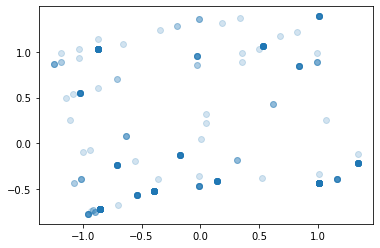

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = np.array(onehot_hl_li)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print("explained variance ratio: %s" % str(pca.explained_variance_ratio_))

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.2)
plt.show()

### Hierachy cluster

<Figure size 576x288 with 0 Axes>

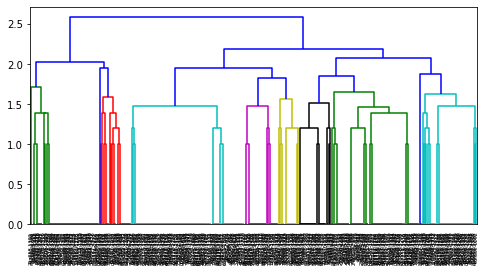

In [0]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(8,4))

X = np.array(onehot_hl_li)
Z = sch.linkage(X, method = 'weighted') # X is a 2d array of observation vectors.
dn = sch.dendrogram(Z, labels = sn_list, orientation = 'top')

plt.show()

In [0]:
cutree = sch.cut_tree(Z, n_clusters=6)
cutree

In [0]:
df['cluster'] = cutree

In [0]:
df.groupby('cluster').sum()

,RegQueryValue,CreateProcessInternal,LoadLibrary,RegEnumValue,RegDeleteKey,RegCreateKey,CopyFile,ExitProcess,DeleteFile,CreateFile,RegSetValue,CreateProcess,OpenProcess
cluster,,,,,,,,,,,,,
0,54,54,54,3,0,51,17,46,15,54,17,54,3
1,62,0,53,0,0,0,0,2,1,55,0,0,0
2,157,51,157,157,133,157,4,13,49,157,157,47,55
3,29,29,29,0,0,6,0,7,2,23,0,23,0
4,113,5,113,0,3,108,2,37,55,113,48,2,2
5,0,1,0,0,0,0,0,0,0,0,0,1,0


分6群結果發現5的資料量非常少只有一筆，其他可以看到第2群多RegDeleteKey操作，在Reg開頭的API操作上比其他群還多

### kMeans

reference: https://github.com/hsiaom26/DSFTA/blob/master/Alg-k-means.ipynb

In [0]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

##### cluster data into K=1..10 clusters #####
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X_r, k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X_r, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'Average within-cluster sum of squares')

Text(0.5, 1.0, 'Elbow for KMeans clustering')

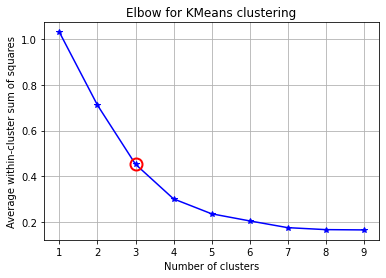

In [0]:
##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

Text(0.5, 0, 'Petal Length')

Text(0, 0.5, 'Sepal Width')

Text(0.5, 1.0, 'Iris Dataset, KMeans clustering with K=3')

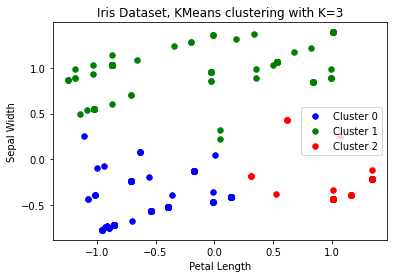

In [0]:
kIdx = 2
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X_r[ind,0],X_r[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset, KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()

用k-means elbows diagram 判斷分3群為最佳

並畫出PCA後的scatter plot上，可以看出這三類能明顯分群

再繼續觀察這三群在call API上的數量有什麼差異

In [0]:
from sklearn.cluster import KMeans
kc = KMeans(n_clusters = 3)
kc.fit(X_r)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df['cluster'] = kc.predict(X_r)
df.groupby('cluster').sum()

,RegQueryValue,CreateProcessInternal,LoadLibrary,RegEnumValue,RegDeleteKey,RegCreateKey,CopyFile,ExitProcess,DeleteFile,CreateFile,RegSetValue,CreateProcess,OpenProcess
cluster,,,,,,,,,,,,,
0,113,4,113,110,109,113,2,3,32,113,113,0,26
1,174,7,165,0,0,105,1,36,52,166,41,0,2
2,128,129,128,50,27,104,20,66,38,123,68,127,32


發現第0群比較多RegEnumValue, RegDeleteKey, RegSetValue上的操作

第1群在Loadlibrary, CreateFile等比較多

第3群則是CreateProcessInternal, CreateProcess的操作較多

In [0]:
import scipy
import sklearn.metrics as sm 

plt.figure(figsize=(8,4))

X = np.array(onehot_hl_li)

# the double loop can be improved, how?
matrix = list()
for i in sn_list:
    li = list()
    for j in sn_list:
        i_ser = df.loc[i]
        j_ser = df.loc[j]

        _inter_ser = i_ser & j_ser
        _union_ser = i_ser | j_ser

        if sum(_union_ser) > 0:
            jaccard = round(sum(_inter_ser)/sum(_union_ser), 4)
            li.append(1.0 - jaccard)
        else:
            li.append(0.0)

    matrix.append(li)
    # end of create distance matrix

D = scipy.spatial.distance.squareform(matrix)
Z = sch.linkage(D, method = 'weighted') # X is a 1d condensed distance matrix.
# hack Z
Z = [[z[0], z[1], 0.005 if z[2]==0 else z[2], z[3]] for z in Z]
# end of hack Z
dn = sch.dendrogram(Z, labels = sn_list, orientation = 'top')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90, fontsize=8)
plt.ylim(0.0, 0.5)
plt.show()

### DotMatrix

In [0]:
def createDotMatrix(hl):
    n = len(hl)

    x = hl.li
    y = hl.li

    matched = [[0 for j in range(n)] for i in range(n)]
    for i, t_api_x in enumerate(x):
        for j, t_api_y in enumerate(y):
            if hl.par == True:
                api_x = t_api_x[1] + t_api_x[2]
                api_y = t_api_y[1] + t_api_y[2]
            else:
                api_x = t_api_x[1]
                api_y = t_api_y[1]
            if api_x == api_y:
                matched[j][i] = 1.0

    return matched

In [0]:
hl = hl_list[0]
matched = createDotMatrix(hl)

<Figure size 864x864 with 0 Axes>

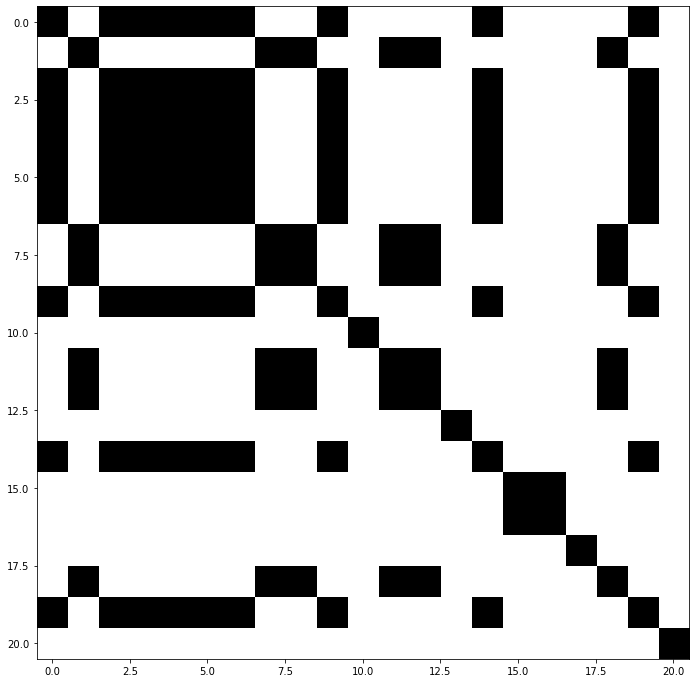

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(matched, cmap='Greys')
plt.show()